In [1]:
import json
import logging
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from typing import Optional
from tqdm.auto import tqdm

from dotenv import load_dotenv
load_dotenv('../.env')

from kaggle_competition_assistant import KaggleCompetitionAssistant
from kaggle_competition_assistant import llm

from sentence_transformers import SentenceTransformer

# Set the maximum number of rows to display
pd.set_option('display.max_rows', 100)
tqdm.pandas()

logging.basicConfig(level=logging.WARNING, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

## Ingestion

In [2]:
def create_assistant(competition_slug):
    competition_data_path = '../data/' + competition_slug
    assistant = KaggleCompetitionAssistant(competition_slug, competition_data_path=competition_data_path, index_type='opensearch',
                                           index_configs={'index_name': 'kaggle-assistant-' + competition_slug})
    return assistant

In [3]:
competition_slug = 'llm-zoomcamp-2024-competition'
assistant = create_assistant(competition_slug)

/Users/vladkha/Desktop/Workspace/Coding/kaggle-competition-copilot/.venv/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Creating document embeddings:   0%|          | 0/91 [00:00<?, ?it/s]

## End2End evaluation

### Load ground truth

In [4]:
df_question = pd.read_csv(f'../data/evaluation/{competition_slug}-ground-truth.csv')
ground_truth = df_question.to_dict(orient='records')

df_question.sample(5)

,doc_id,question,answer
12,7,What are some examples of problem IDs and thei...,"Examples include 11919 with answer 11, 8513 wi..."
7,3,What is the main objective of the competition?,To predict the correct answer for each problem...
29,20,How many files are provided in the dataset?,7
44,90,How impactful can prompt engineering be in thi...,Significant improvements in scores have been o...
20,13,What is the name of the column containing the ...,answer


### Generate assistant answers

In [5]:
def generate_assistant_answers(assistant, ground_truth, retrieval_configs={}, num_results=5, generation_llm_prompt=None):
    answers = {}
    
    for i, rec in enumerate(tqdm(ground_truth)):
        if i in answers:
            continue
    
        answer_assistant = assistant.query(rec['question'],
                                           retrieval_configs=retrieval_configs, retrieval_n_results=num_results,
                                           generation_llm_prompt=generation_llm_prompt)[0]
    
        answers[i] = {
            'question': rec['question'],
            'answer_assistant': answer_assistant,
            'answer_orig': rec['answer'],
            'document_orig': rec['doc_id'],
        }
        
    return answers

In [6]:
assistant_answers = generate_assistant_answers(assistant, ground_truth,
                                               retrieval_configs={
                                                   'search_type': 'hybrid_rff',
                                                   'boost_dict': {"source": 9.15, "section": 2.21, "text": 0.63} # after hyperparameter tuning
                                               }, num_results=10)

  0%|          | 0/45 [00:00<?, ?it/s]

In [7]:
df_answers = pd.DataFrame(assistant_answers.values(), columns=['question', 'answer_assistant', 'answer_orig', 'document_orig'])
df_answers.to_csv(f'../data/evaluation/{competition_slug}-rag-answers.csv', index=False)
df_answers.sample(5, random_state=42)

,question,answer_copilot,answer_orig,document_orig
39,What is the score of ArturG's submission?,ArturG's submission has a score of **0.93750**.,0.93750,29
25,What is the unique identifier for each problem...,The unique identifier for each problem in the ...,problem_id,17
26,What is the language of the mathematical probl...,The mathematical problem statements in the `ru...,Russian,18
43,What accuracy did the Claude Sonnet 3.5 model ...,The Claude Sonnet 3.5 model achieved an accura...,The Claude Sonnet 3.5 model achieved 85% accur...,89
35,How many columns are present in the dataset?,The dataset has 19 columns.,19,25


### Cosine similarity metric

In [8]:
model_name = 'Lajavaness/bilingual-embedding-large' # best Semantic Textual Similarity model according to https://huggingface.co/spaces/mteb/leaderboard 
model = SentenceTransformer(model_name, trust_remote_code=True)

In [9]:
def compute_similarity(record):
    answer_orig = record['answer_orig']
    answer_rag = record['answer_assistant']
    
    v_rag = model.encode(answer_rag)
    v_orig = model.encode(answer_orig)
    
    return v_rag.dot(v_orig)

In [10]:
df_answers['cosine_similarity'] = df_answers.progress_apply(lambda row: compute_similarity(row), axis=1)

  0%|          | 0/45 [00:00<?, ?it/s]

In [11]:
df_answers.head()

,question,answer_copilot,answer_orig,document_orig,cosine_similarity
0,What is the name of the Kaggle competition?,"The Kaggle competition is called ""LLM Zoomcamp...",LLM Zoomcamp 2024 Competition,0,0.811396
1,What type of problems are participants asked t...,Participants in the LLM Zoomcamp 2024 Competit...,High school mathematical problems,1,0.574622
2,What is the main objective of the competition?,The main objective of the competition is to de...,Participants need to solve high school mathema...,2,0.639532
3,Where do the mathematics problems originate from?,The mathematics problems originate from the [Е...,The problems originate from the Unified State ...,2,0.965727
4,How were the problems translated?,The problems were translated from Russian to E...,Each problem was translated to English using G...,2,0.892885


In [12]:
df_answers['cosine_similarity'].describe()

count    45.000000
mean      0.660743
std       0.213638
min       0.006070
25%       0.464731
50%       0.679022
75%       0.848746
max       1.000000
Name: cosine_similarity, dtype: float64

Distribution of cosine similarities plot

/var/folders/pm/jl5fx4c52mg00plwqrbg03tm0000gn/T/ipykernel_2990/3266868292.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


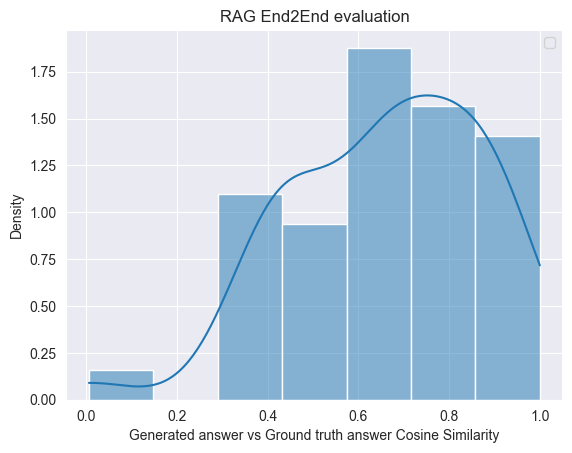

In [13]:
sns.histplot(df_answers['cosine_similarity'], kde=True, stat='density')

plt.title("RAG End2End evaluation")
plt.xlabel("Generated answer vs Ground truth answer Cosine Similarity")
plt.legend()

### LLM-as-a-Judge

In [14]:
llm_judge_aa_template = """
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer compared to the original answer provided.
Based on the relevance and similarity of the generated answer to the original answer, you will classify
it as "NON_RELEVANT", "PARTIALLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Original Answer: {answer_orig}
Question: {question}
Generated Answer: {answer_assistant}

Please analyze the content and context of the generated answer in relation to the original
answer and provide your evaluation in parsable JSON without using any code blocks:
{{
  "relevance": "NON_RELEVANT" | "PARTIALLY_RELEVANT" | "RELEVANT",
  "explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()

llm_judge_aq_template = """
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer to a given question.
Based on the relevance of the generated answer, you will classify it as "NON_RELEVANT", "PARTIALLY_RELEVANT", or "RELEVANT".

The context of the question and answer relate to a Kaggle competition.
Avoid:
- trying to determine the correctness of the answer. Just focus on generic relevance of answer to the topic of the question.
- trying to reason about the specificity of the answer or additional context. Just focus on generic relevance of answer to the topic of the question.

Here is the data for evaluation:
Question: {question}
Generated answer: {answer_assistant}

Please analyze the content of the generated answer in relation to the question and provide your evaluation in parsable JSON without using any code blocks:
{{
  "relevance": "NON_RELEVANT" | "PARTIALLY_RELEVANT" | "RELEVANT",
  "explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()

Sample prompt

In [15]:
q = df_answers['question'].values[0]
a_c = df_answers['answer_assistant'].values[0]
a_o = df_answers['answer_orig'].values[0]
print(llm_judge_aa_template.format(question=q, answer_assistant=a_c, answer_orig=a_o))

You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer compared to the original answer provided.
Based on the relevance and similarity of the generated answer to the original answer, you will classify
it as "NON_RELEVANT", "PARTIALLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Original Answer: LLM Zoomcamp 2024 Competition
Question: What is the name of the Kaggle competition?
Generated Answer: The Kaggle competition is called "LLM Zoomcamp 2024 Competition".

Please analyze the content and context of the generated answer in relation to the original
answer and provide your evaluation in parsable JSON without using any code blocks:
{
  "relevance": "NON_RELEVANT" | "PARTIALLY_RELEVANT" | "RELEVANT",
  "explanation": "[Provide a brief explanation for your evaluation]"
}


In [16]:
def llm_as_a_judge(prompt_template, records):
    evaluations = []
    for i,record in tqdm(records.iterrows(), desc='Evaluating with LLM as a judge', total=len(records)):
        prompt = prompt_template.format(**record)
        
        while True:
            try:
                evaluation = llm(prompt)[0]
                
                # still some scrubbing of code blocks required
                evaluation = evaluation.removeprefix("```json").removesuffix("```")
                
                evaluation = json.loads(evaluation)
                evaluations.append(evaluation)
                break
            except Exception as e:
                print(evaluation)
                print(f'Failed generating judgement: {e}. Trying again...')
        
    df_evaluations = pd.DataFrame(evaluations)
    
    return df_evaluations

In [17]:
df_evaluations_aa = llm_as_a_judge(llm_judge_aa_template, df_answers)
df_answers['aa_relevance'] = df_evaluations_aa['relevance']
df_answers['aa_relevance_explanation'] = df_evaluations_aa['explanation']

Evaluating with LLM as a judge:   0%|          | 0/45 [00:00<?, ?it/s]

In [18]:
df_answers['aa_relevance'].value_counts()

aa_relevance
RELEVANT              37
PARTIALLY_RELEVANT     4
NON_RELEVANT           4
Name: count, dtype: int64

In [19]:
df_answers['aa_relevance'].value_counts(normalize=True)

aa_relevance
RELEVANT              0.822222
PARTIALLY_RELEVANT    0.088889
NON_RELEVANT          0.088889
Name: proportion, dtype: float64

In [20]:
df_answers[df_answers['aa_relevance'] == 'NON_RELEVANT']

,question,answer_copilot,answer_orig,document_orig,cosine_similarity,aa_relevance,aa_relevance_explanation
12,What are some examples of problem IDs and thei...,The provided context doesn't include specific ...,"Examples include 11919 with answer 11, 8513 wi...",7,0.408701,NON_RELEVANT,The generated answer completely misses the exa...
28,What is the initial value for the 'answer' col...,The initial value for the 'answer' column in t...,No answer,19,0.600175,NON_RELEVANT,"The original answer is 'No answer', meaning th..."
36,Who won the Kaggle competition?,The provided context does not mention the winn...,CHINONSO ODIAKA,26,0.006070,NON_RELEVANT,The generated answer is not relevant to the or...
41,What are some suggested ways to utilize large ...,The provided context does not suggest specific...,"Experimenting with various system prompts, suc...",87,0.502092,NON_RELEVANT,The generated answer completely ignores the in...


In [21]:
df_evaluations_aq = llm_as_a_judge(llm_judge_aq_template, df_answers)
df_answers['aq_relevance'] = df_evaluations_aq['relevance']
df_answers['aq_relevance_explanation'] = df_evaluations_aq['explanation']

Evaluating with LLM as a judge:   0%|          | 0/45 [00:00<?, ?it/s]

In [22]:
df_answers['aq_relevance'].value_counts()

aq_relevance
RELEVANT              39
PARTIALLY_RELEVANT     4
NON_RELEVANT           2
Name: count, dtype: int64

In [23]:
df_answers['aq_relevance'].value_counts(normalize=True)

aq_relevance
RELEVANT              0.866667
PARTIALLY_RELEVANT    0.088889
NON_RELEVANT          0.044444
Name: proportion, dtype: float64

In [24]:
df_answers[df_answers['aq_relevance'] == 'PARTIALLY_RELEVANT']

,question,answer_copilot,answer_orig,document_orig,cosine_similarity,aa_relevance,aa_relevance_explanation,aq_relevance,aq_relevance_explanation
3,Where do the mathematics problems originate from?,The mathematics problems originate from the [Е...,The problems originate from the Unified State ...,2,0.965727,RELEVANT,The generated answer is identical to the origi...,PARTIALLY_RELEVANT,"The answer mentions a source of math problems,..."
8,How is accuracy calculated in this competition?,Accuracy is calculated by dividing the number ...,Accuracy is defined as the proportion of corre...,4,0.900809,RELEVANT,Both the original and generated answers define...,PARTIALLY_RELEVANT,The answer provides a general definition of ac...
10,What is the primary evaluation metric for this...,The primary evaluation metric for this competi...,Accuracy,6,0.464731,RELEVANT,The generated answer correctly identifies 'acc...,PARTIALLY_RELEVANT,While the answer mentions an evaluation metric...
14,What is the recommended action to take before ...,"Before submitting your file, ensure you valida...",Make sure to validate the submission file form...,7,0.952906,RELEVANT,The generated answer is essentially a rephrase...,PARTIALLY_RELEVANT,The answer is partially relevant as it mention...


In [47]:
df_answers.to_csv(f'../data/evaluation/{competition_slug}-end2end-evaluation.csv', index=False)

### Evaluation for 2nd dataset

In [30]:
def evaluate_end2end(competition_slug: str, 
                     retrieval_configs: Optional[dict] = None, num_results: int = 5, 
                     generation_llm_prompt: Optional[str] = None):
    assistant = create_assistant(competition_slug)
    
    df_question = pd.read_csv(f'../data/evaluation/{competition_slug}-ground-truth.csv')
    ground_truth = df_question.to_dict(orient='records')
    
    assistant_answers = generate_assistant_answers(assistant, ground_truth,
                                                 retrieval_configs=retrieval_configs, num_results=num_results, generation_llm_prompt=generation_llm_prompt)
    
    df_answers = pd.DataFrame(assistant_answers.values(), columns=['question', 'answer_assistant', 'answer_orig', 'document_orig'])
    # df_answers.to_csv(f'../data/evaluation/{competition_slug}-rag-answers.csv', index=False)
    
    # cosine sim
    df_answers['cosine_similarity'] = df_answers.progress_apply(lambda row: compute_similarity(row), axis=1)
    
    # aa relevance
    df_evaluations_aa = llm_as_a_judge(llm_judge_aa_template, df_answers)
    df_answers['aa_relevance'] = df_evaluations_aa['relevance']
    df_answers['aa_relevance_explanation'] = df_evaluations_aa['explanation']
    
    # aq relevance
    df_evaluations_aq = llm_as_a_judge(llm_judge_aq_template, df_answers)
    df_answers['aq_relevance'] = df_evaluations_aq['relevance']
    df_answers['aq_relevance_explanation'] = df_evaluations_aq['explanation']
    
    return df_answers

In [31]:
competition_slug = 'rohlik-orders-forecasting-challenge'
df_answers_2 = evaluate_end2end(competition_slug,
                                retrieval_configs={'search_type': 'semantic'}, num_results=10)

/Users/vladkha/Desktop/Workspace/Coding/kaggle-competition-copilot/.venv/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Creating document embeddings:   0%|          | 0/1117 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Evaluating with LLM as a judge:   0%|          | 0/115 [00:00<?, ?it/s]

Evaluating with LLM as a judge:   0%|          | 0/115 [00:00<?, ?it/s]


{
  "relevance": "PARTIALLY_RELEVANT",
  "explanation": "The answer acknowledges the lack of explicitly stated restrictions, but it also mentions various tools that can be used for prediction generation, which is tangentially related to the question's focus on hardware/software restrictions."
}
``` 

Failed generating judgement: Extra data: line 6 column 1 (char 297). Trying again...


In [32]:
df_answers_2['cosine_similarity'].describe()

count    115.000000
mean       0.681473
std        0.187289
min        0.109915
25%        0.558338
50%        0.722075
75%        0.826727
max        0.992766
Name: cosine_similarity, dtype: float64

In [40]:
df_answers_2['aa_relevance'].value_counts()

aa_relevance
RELEVANT              61
PARTIALLY_RELEVANT    34
NON_RELEVANT          20
Name: count, dtype: int64

In [41]:
df_answers_2['aa_relevance'].value_counts(normalize=True)

aa_relevance
RELEVANT              0.530435
PARTIALLY_RELEVANT    0.295652
NON_RELEVANT          0.173913
Name: proportion, dtype: float64

In [35]:
df_answers_2['aq_relevance'].value_counts()

aq_relevance
RELEVANT              67
PARTIALLY_RELEVANT    34
NON_RELEVANT          14
Name: count, dtype: int64

In [42]:
df_answers_2['aq_relevance'].value_counts(normalize=True)

aq_relevance
RELEVANT              0.582609
PARTIALLY_RELEVANT    0.295652
NON_RELEVANT          0.121739
Name: proportion, dtype: float64

In [48]:
df_answers_2.to_csv(f'../data/evaluation/{competition_slug}-end2end-evaluation.csv', index=False)

### Evaluation with different prompt

In [49]:
improved_prompt_template = """
You are a Kaggle competition assistant.
Answer the QUESTION based on the CONTEXT from the web page about the competition.
Use only the facts from the CONTEXT when answering the QUESTION.
Be concise and to the point.

QUESTION: {question}

CONTEXT:
{context}
""".strip()

In [50]:
competition_slug = 'llm-zoomcamp-2024-competition'
df_answers_zoomcamp_2 = evaluate_end2end(competition_slug,
                                         retrieval_configs={
                                             'search_type': 'hybrid_rff',
                                             'boost_dict': {"source": 9.15, "section": 2.21, "text": 0.63}
                                         }, num_results=10,
                                         generation_llm_prompt=improved_prompt_template)
df_answers_zoomcamp_2.to_csv(f'../data/evaluation/{competition_slug}-end2end-evaluation2.csv', index=False)

/Users/vladkha/Desktop/Workspace/Coding/kaggle-competition-copilot/.venv/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Creating document embeddings:   0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Evaluating with LLM as a judge:   0%|          | 0/45 [00:00<?, ?it/s]


{
  "relevance": "PARTIALLY_RELEVANT",
  "explanation": "The generated answer mentions solving high school math problems, which aligns with the original answer. However, it adds details about language and model development that are not present in the original answer. Therefore, it's partially relevant."
}
``` 

Failed generating judgement: Extra data: line 6 column 1 (char 308). Trying again...


Evaluating with LLM as a judge:   0%|          | 0/45 [00:00<?, ?it/s]

In [51]:
df_answers_zoomcamp_2['cosine_similarity'].describe()

count    45.000000
mean      0.830977
std       0.215939
min       0.035656
25%       0.795087
50%       0.902256
75%       1.000000
max       1.000000
Name: cosine_similarity, dtype: float64

In [52]:
df_answers_zoomcamp_2['aa_relevance'].value_counts()

aa_relevance
RELEVANT              35
PARTIALLY_RELEVANT     5
NON_RELEVANT           5
Name: count, dtype: int64

In [53]:
df_answers_zoomcamp_2['aa_relevance'].value_counts(normalize=True)

aa_relevance
RELEVANT              0.777778
PARTIALLY_RELEVANT    0.111111
NON_RELEVANT          0.111111
Name: proportion, dtype: float64

In [54]:
df_answers_zoomcamp_2['aq_relevance'].value_counts()

aq_relevance
RELEVANT              26
PARTIALLY_RELEVANT    11
NON_RELEVANT           8
Name: count, dtype: int64

In [55]:
df_answers_zoomcamp_2['aq_relevance'].value_counts(normalize=True)

aq_relevance
RELEVANT              0.577778
PARTIALLY_RELEVANT    0.244444
NON_RELEVANT          0.177778
Name: proportion, dtype: float64

In [56]:
competition_slug = 'rohlik-orders-forecasting-challenge'
df_answers_rohlik_2 = evaluate_end2end(competition_slug,
                                       retrieval_configs={'search_type': 'semantic'}, num_results=10,
                                       generation_llm_prompt=improved_prompt_template)
df_answers_rohlik_2.to_csv(f'../data/evaluation/{competition_slug}-end2end-evaluation2.csv', index=False)

/Users/vladkha/Desktop/Workspace/Coding/kaggle-competition-copilot/.venv/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Creating document embeddings:   0%|          | 0/1117 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Evaluating with LLM as a judge:   0%|          | 0/115 [00:00<?, ?it/s]

Evaluating with LLM as a judge:   0%|          | 0/115 [00:00<?, ?it/s]


{
  "relevance": "PARTIALLY_RELEVANT",
  "explanation": "The answer focuses on using the features to "correct" the target, which is not directly addressing the question of dealing with missing features in the test set. However, it does mention training separate models to predict the value of the missing features, which is partially relevant to the question."
}

Failed generating judgement: Expecting ',' delimiter: line 4 column 64 (char 103). Trying again...


In [57]:
df_answers_rohlik_2['cosine_similarity'].describe()

count    115.000000
mean       0.756441
std        0.184881
min        0.067134
25%        0.634209
50%        0.771948
75%        0.905124
max        1.000000
Name: cosine_similarity, dtype: float64

In [58]:
df_answers_rohlik_2['aa_relevance'].value_counts()

aa_relevance
RELEVANT              64
PARTIALLY_RELEVANT    38
NON_RELEVANT          13
Name: count, dtype: int64

In [59]:
df_answers_rohlik_2['aa_relevance'].value_counts(normalize=True)

aa_relevance
RELEVANT              0.556522
PARTIALLY_RELEVANT    0.330435
NON_RELEVANT          0.113043
Name: proportion, dtype: float64

In [60]:
df_answers_rohlik_2['aq_relevance'].value_counts()

aq_relevance
RELEVANT              57
PARTIALLY_RELEVANT    48
NON_RELEVANT          10
Name: count, dtype: int64

In [61]:
df_answers_rohlik_2['aq_relevance'].value_counts(normalize=True)

aq_relevance
RELEVANT              0.495652
PARTIALLY_RELEVANT    0.417391
NON_RELEVANT          0.086957
Name: proportion, dtype: float64